# Part 1: Data Ingestion


This demo showcases financial fraud prevention and using the MLRun feature store to define complex features that help identify fraud. Fraud prevention specifically is a challenge as it requires processing raw transaction and events in real-time and being able to quickly respond and block transactions before they occur.

To address this, we create a development pipeline and a production pipeline. Both pipelines share the same feature engineering and model code, but serve data very differently. Furthermore, we automate the data and model monitoring process, identify drift and trigger retraining in a CI/CD pipeline. This process is described in the diagram below:

![Feature store demo diagram - fraud prevention](../../_static/images/feature_store_demo_diagram.png)

The raw data is described as follows:

| TRANSACTIONS                                                                    || &#x2551; |USER EVENTS                                                                           || 
|-----------------|----------------------------------------------------------------|----------|-----------------|----------------------------------------------------------------|
| **age**         | age group value 0-6. Some values are marked as U for unknown   | &#x2551; | **source**      | The party/entity related to the event                          |
| **gender**      | A character to define the age                                  | &#x2551; | **event**       | event, such as login or password change                        |
| **zipcodeOri**  | ZIP code of the person originating the transaction             | &#x2551; | **timestamp**   | The date and time of the event                                 |
| **zipMerchant** | ZIP code of the merchant receiving the transaction             | &#x2551; |                 |                                                                |
| **category**    | category of the transaction (e.g., transportation, food, etc.) | &#x2551; |                 |                                                                |
| **amount**      | the total amount of the transaction                            | &#x2551; |                 |                                                                |
| **fraud**       | whether the transaction is fraudulent                          | &#x2551; |                 |                                                                |
| **timestamp**   | the date and time in which the transaction took place          | &#x2551; |                 |                                                                |
| **source**      | the ID of the party/entity performing the transaction          | &#x2551; |                 |                                                                |
| **target**      | the ID of the party/entity receiving the transaction           | &#x2551; |                 |                                                                |
| **device**      | the device ID used to perform the transaction                  | &#x2551; |                 |                                                                |

This notebook introduces how to **Ingest** different data sources to the **Feature Store**.

The following FeatureSets will be created:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Label**: Fraud label for the data.

By the end of this tutorial you’ll learn how to:

- Create an ingestion pipeline for each data source.
- Define preprocessing, aggregation and validation of the pipeline.
- Run the pipeline locally within the notebook.
- Launch a real-time function to ingest live data.
- Schedule a cron to run the task when needed.

In [1]:
project_name = 'fraud-demo'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2021-10-28 11:25:47,346 [info] loaded project fraud-demo from MLRun DB


## Step 1 - Fetch, Process and Ingest our datasets

## 1.1 - Transactions

### Transactions

In [3]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

In [4]:
import pandas as pd

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data.sample(50000), new_period='2d')

# Preview
transactions_data.head(3)

step age gender  zipcodeOri  zipMerchant           category  amount  \
272598    90   2      F       28007        28007            es_food   25.10   
298620    98   4      F       28007        28007  es_transportation   13.59   
156749    55   3      M       28007        28007  es_transportation   26.62   

        fraud                     timestamp       source       target  \
272598      0 2021-10-26 18:44:13.733660936  C1255231772    M85975013   
298620      0 2021-10-27 23:56:25.684188565  C1194320883  M1823072687   
156749      0 2021-10-28 01:36:14.157330333   C880299982   M348934600   

                                  device  
272598  501e9a1d7c324c46bc540106a2e519ac  
298620  3867e8da0f934fff87b17efd655150a4  
156749  36c74947bc594eef91bc294135d60db3

### Transactions - Create a FeatureSet and Preprocessing Pipeline
Create the FeatureSet (data pipeline) definition for the **credit transaction processing** which describes the offline/online data transformations and aggregations.<br>
The feature store will automatically add an offline `parquet` target and an online `NoSQL` target by using `set_targets()`.

The data pipeline consists of:

* **Extracting** the data components (hour, day of week)
* **Mapping** the age values
* **One hot encoding** for the transaction category and the gender
* **Aggregating** the amount (avg, sum, count, max over 2/12/24 hour time windows)
* **Aggregating** the transactions per category (over 14 days time windows)
* **Writing** the results to **offline** (Parquet) and **online** (NoSQL) targets 

In [5]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

In [6]:
# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                 entities=[fstore.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

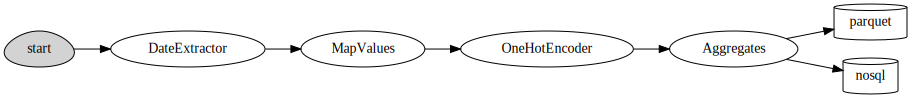

In [7]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))


# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')


# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

### Transactions - Ingestion

In [8]:
# Ingest our transactions dataset through our defined pipeline
transactions_df = fstore.ingest(transaction_set, transactions_data, 
                 infer_options=fstore.InferOptions.default())

transactions_df.head(3)

amount_max_2h  amount_max_12h  amount_max_24h  amount_sum_2h  \
source                                                                      
C1255231772          25.10           25.10           25.10          25.10   
C1194320883          13.59           25.01           52.45          13.59   
C880299982           32.80          197.96          197.96          59.42   

             amount_sum_12h  amount_sum_24h  amount_count_2h  \
source                                                         
C1255231772           25.10           25.10              1.0   
C1194320883           51.95          178.16              1.0   
C880299982           304.40          304.40              2.0   

             amount_count_12h  amount_count_24h  amount_avg_2h  ...  \
source                                                          ...   
C1255231772               1.0               1.0          25.10  ...   
C1194320883               4.0               7.0          13.59  ...   
C880299982                5.0               5.0          29.71  ...   

             category_es_contents  category_es_travel  category_es_leisure  \
source                                                                       
C1255231772                     0                   0                    0   
C1194320883                     0                   0                    0   
C880299982                      0                   0                    0   

             amount  fraud                     timestamp       target  \
source                                                                  
C1255231772   25.10      0 2021-10-26 18:44:13.733660936    M85975013   
C1194320883   13.59      0 2021-10-27 23:56:25.684188565  M1823072687   
C880299982    26.62      0 2021-10-28 01:36:14.157330333   M348934600   

                                       device  timestamp_hour  \
source                                                          
C1255231772  501e9a1d7c324c46bc540106a2e519ac              18   
C1194320883  3867e8da0f934fff87b17efd655150a4              23   
C880299982   36c74947bc594eef91bc294135d60db3               1   

             timestamp_day_of_week  
source                              
C1255231772                      1  
C1194320883                      2  
C880299982                       3  

[3 rows x 58 columns]

## 1.2 - User Events

### User Events - Fetching

In [9]:
# Fetch our user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in our online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')

# Preview
user_events_data.head(3)

source           event                     timestamp
0  C1974668487  details_change 2021-10-27 20:35:27.982579086
1  C1973547259           login 2021-10-27 23:37:02.239719508
2   C515668508           login 2021-10-27 20:10:08.520896302

### User Events - Create a FeatureSet and Preprocessing Pipeline

Now we will define the events feature set.
This is a pretty straight forward pipeline in which we only one hot encode the event categories and save the data to the default targets.

In [10]:
user_events_set = fstore.FeatureSet("events",
                           entities=[fstore.Entity("source")],
                           timestamp_key='timestamp', 
                           description="user events feature set")

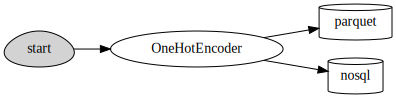

In [11]:
# Define and add value mapping
events_mapping = {'event': list(user_events_data.event.unique())}

# One Hot Encode
user_events_set.graph.to(OneHotEncoder(mapping=events_mapping))

# Add default (offline-parquet & online-nosql) targets
user_events_set.set_targets()

# Plot the pipeline so we can see the different steps
user_events_set.plot(rankdir="LR", with_targets=True)

### User Events - Ingestion

In [12]:
# Ingestion of our newly created events feature set
events_df = fstore.ingest(user_events_set, user_events_data)
events_df.head(3)

event_details_change  event_login  event_password_change  \
source                                                                  
C1974668487                     1            0                      0   
C1973547259                     0            1                      0   
C515668508                      0            1                      0   

                                timestamp  
source                                     
C1974668487 2021-10-27 20:35:27.982579086  
C1973547259 2021-10-27 23:37:02.239719508  
C515668508  2021-10-27 20:10:08.520896302

## Step 2 - Create a labels dataset for model training

### Label Set - Create a FeatureSet
This feature set contains the label for the fraud demo, it will be ingested directly to the default targets without any changes

In [13]:
def create_labels(df):
    labels = df[['fraud','source','timestamp']].copy()
    labels = labels.rename(columns={"fraud": "label"})
    labels['timestamp'] = labels['timestamp'].astype("datetime64[ms]")
    labels['label'] = labels['label'].astype(int)
    labels.set_index('source', inplace=True)
    return labels

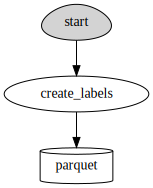

In [14]:
# Define the "labels" feature set
labels_set = fstore.FeatureSet("labels", 
                           entities=[fstore.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels",
                           engine="pandas")

labels_set.graph.to(name="create_labels", handler=create_labels)

# specify only Parquet (offline) target since its not used for real-time
labels_set.set_targets(['parquet'], with_defaults=False)
labels_set.plot(with_targets=True)

### Label Set - Ingestion

In [15]:
# Ingest the labels feature set
labels_df = fstore.ingest(labels_set, transactions_data)
labels_df.head(3)

1000
None


label               timestamp
source                                    
C1255231772      0 2021-10-26 18:44:13.733
C1194320883      0 2021-10-27 23:56:25.684
C880299982       0 2021-10-28 01:36:14.157

## Step 3 - Deploy a real-time pipeline

When dealing with real-time aggregation, it's important to be able to update these aggregations in real-time.
For this purpose, we will create live serving functions that will update the online feature store of the `transactions` FeatureSet and `Events` FeatureSet.

Using MLRun's `serving` runtime, craetes a nuclio function loaded with our feature set's computational graph definition
and an `HttpSource` to define the HTTP trigger.

Notice that the implementation below does not require any rewrite of the pipeline logic.

## 3.1 - Transactions

### Transactions - Deploy our FeatureSet live endpoint

In [16]:
# Create iguazio v3io stream and transactions push API endpoint
transaction_stream = f'v3io:///projects/{project.name}/streams/transaction'
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

In [17]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# as any other datasource, we will define the `key` and `time` fields here too.
http_source = mlrun.datastore.sources.HttpSource(key_field='source', time_field='timestamp')
transaction_set.spec.source = http_source

# Create a real-time serverless function definition to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = (mlrun.new_function('ingest-transactions', kind='serving', image='mlrun/mlrun')).with_code(body=" ")

# Add stream trigger (must first create the stream)
function.add_v3io_stream_trigger(transaction_stream)

#
run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [18]:
# Deploy the transactions feature set's ingestion service using the feature set
# and all the defined resources above.
transaction_set_endpoint = fstore.deploy_ingestion_service(featureset=transaction_set,
                                                       run_config=run_config)

> 2021-09-19 17:58:50,402 [info] Starting remote function deploy
2021-09-19 17:58:50  (info) Deploying function
2021-09-19 17:58:50  (info) Building
2021-09-19 17:58:50  (info) Staging files and preparing base images
2021-09-19 17:58:50  (info) Building processor image
2021-09-19 17:58:52  (info) Build complete
2021-09-19 17:59:01  (info) Function deploy complete
> 2021-09-19 17:59:01,461 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-ingest-transactions.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-admin-ingest-transactions-fraud-demo-admin.default-tenant.app.jnewriujxdig.iguazio-cd1.com/']}


### Transactions - Test the feature set HTTP endpoint

By defining our `transactions` feature set we can now use MLRun and Storey to deploy it as a live endpoint, ready to ingest new data!

Using MLRun's `serving` runtime, we will create a nuclio function loaded with our feature set's computational graph definition and an `HttpSource` to define the HTTP trigger.

In [19]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
transaction_sample = json.loads(transactions_data.sample(1).to_json(orient='records'))[0]
transaction_sample['timestamp'] = str(pd.Timestamp.now())
transaction_sample

{'step': 99,
 'age': '2',
 'gender': 'F',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 2.62,
 'fraud': 0,
 'timestamp': '2021-09-19 17:59:01.571694',
 'source': 'C1078351181',
 'target': 'M1823072687',
 'device': '25209f138bd847ce8432c6109d2ac2f4'}

In [20]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=transaction_sample).text

'{"id": "c025bd2c-e929-4038-b44b-acbfdadb9006"}'

## 3.2 - User Events

### User Events - Deploy our FeatureSet live endpoint
Deploy the events feature set's ingestion service using the feature set and all the previously defined resources.

In [21]:
# Create iguazio v3io stream and transactions push API endpoint
events_stream = f'v3io:///projects/{project.name}/streams/events'
events_pusher = mlrun.datastore.get_stream_pusher(events_stream)

In [22]:
# Create a `serving` "base function" to deploy the ingestion function on
# the serving runtimes enables the deployment of our feature set's computational graph
function = (mlrun.new_function('ingest-events', kind='serving', image='mlrun/mlrun')).with_code(body=" ")

# Add stream trigger
function.add_v3io_stream_trigger(events_stream)

#
run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [23]:
# Deploy the transactions feature set's ingestion service using the feature set
# and all the defined resources above.
events_set_endpoint = fstore.deploy_ingestion_service(name="ingest-events", featureset=user_events_set,
                                                  source=http_source, run_config=run_config)

> 2021-09-19 17:59:01,795 [info] Starting remote function deploy
2021-09-19 17:59:02  (info) Deploying function
2021-09-19 17:59:02  (info) Building
2021-09-19 17:59:02  (info) Staging files and preparing base images
2021-09-19 17:59:02  (info) Building processor image
2021-09-19 17:59:03  (info) Build complete
> 2021-09-19 17:59:12,356 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-demo-admin-ingest-events.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-demo-admin-ingest-events-fraud-demo-admin.default-tenant.app.jnewriujxdig.iguazio-cd1.com/']}


### User Events - Test the feature set HTTP endpoint

In [24]:
# Select a sample from the events dataset and serialize it to JSON
user_events_sample = json.loads(user_events_data.sample(1).to_json(orient='records'))[0]
user_events_sample['timestamp'] = str(pd.Timestamp.now())
user_events_sample

{'source': 'C1327677398',
 'event': 'login',
 'timestamp': '2021-09-19 17:59:12.452910'}

In [25]:
# Post the sample to the ingestion endpoint
requests.post(events_set_endpoint, json=user_events_sample).text

'{"id": "7e4ce1c3-68ef-4462-89b4-5203d2d01dea"}'

## Done!

You've completed Part 1 of the data-ingestion with the feature store.
Proceed to [Part 2](02-create-training-model.ipynb) to learn how to train an ML model using the feature store data.